In [1]:
%load_ext autoreload
%autoreload 2
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.potential import (
    LJ,
    DE,
)
from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH, PDB_PATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot, residuals_from_keys
from ff_energy.logs.logging import hide_logs
from ff_energy.ffe.potential import LJ, LJ_bound, DE

hide_logs()
import scienceplots
set_style(no_latex=True)

from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json
from ff_energy.ffe.structure import atom_key_pairs

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, \
    PKL_PATH, get_structures

0 ('C', 'C')
1 ('C', 'CG331')
2 ('C', 'CL')
3 ('C', 'CLA')
4 ('C', 'H')
5 ('C', 'HGA3')
6 ('C', 'HGP1')
7 ('C', 'HT')
8 ('C', 'OG311')
9 ('C', 'OT')
10 ('C', 'POT')
11 ('CG331', 'CG331')
12 ('CG331', 'CL')
13 ('CG331', 'CLA')
14 ('CG331', 'H')
15 ('CG331', 'HGA3')
16 ('CG331', 'HGP1')
17 ('CG331', 'HT')
18 ('CG331', 'OG311')
19 ('CG331', 'OT')
20 ('CG331', 'POT')
21 ('CL', 'CL')
22 ('CL', 'CLA')
23 ('CL', 'H')
24 ('CL', 'HGA3')
25 ('CL', 'HGP1')
26 ('CL', 'HT')
27 ('CL', 'OG311')
28 ('CL', 'OT')
29 ('CL', 'POT')
30 ('CLA', 'CLA')
31 ('CLA', 'H')
32 ('CLA', 'HGA3')
33 ('CLA', 'HGP1')
34 ('CLA', 'HT')
35 ('CLA', 'OG311')
36 ('CLA', 'OT')
37 ('CLA', 'POT')
38 ('H', 'H')
39 ('H', 'HGA3')
40 ('H', 'HGP1')
41 ('H', 'HT')
42 ('H', 'OG311')
43 ('H', 'OT')
44 ('H', 'POT')
45 ('HGA3', 'HGA3')
46 ('HGA3', 'HGP1')
47 ('HGA3', 'HT')
48 ('HGA3', 'OG311')
49 ('HGA3', 'OT')
50 ('HGA3', 'POT')
51 ('HGP1', 'HGP1')
52 ('HGP1', 'HT')
53 ('HGP1', 'OG311')
54 ('HGP1', 'OT')
55 ('HGP1', 'POT')
56 ('HT', 'HT'

<Figure size 100x100 with 0 Axes>

#  Gathering Data

In [2]:
sapt_data = pd.read_csv("data/sapt.csv")
RS = [float(_.strip().replace("D","E")) for _ in sapt_data["RS"]]
ETOT = [float(_.strip().replace("D","E")) for _ in sapt_data["ETOT"]]

(-50.0, 50.0)

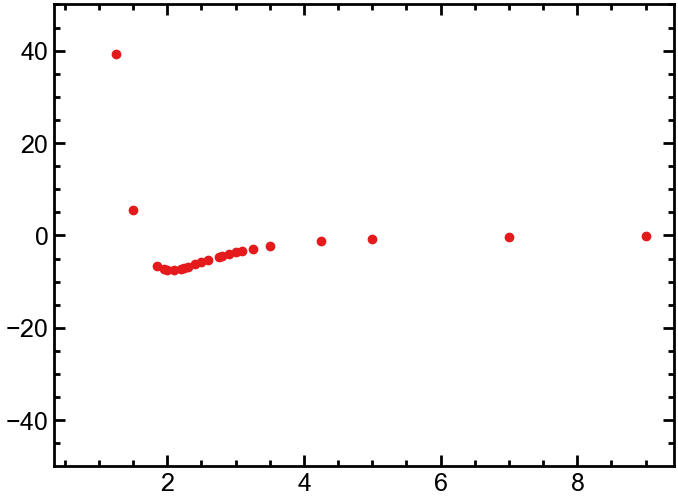

In [3]:
plt.scatter(RS, ETOT)
plt.ylim(-50,50)

In [4]:
ci_outfiles = list(Path("/home/boittier/homeb/water_dimer2/pbe0dz").glob("*/coloumb/*py.out"))

In [5]:
def stem2key(s):
    return str(s).split("_")[0]+".xyz"

ci_res = {stem2key(ci_outfiles[i].stem): float(open(ci_outfiles[i]
          ).readlines()[-1].split()[0]) for i,v in enumerate(ci_outfiles)}
# ci_res

In [6]:
len(ci_res.keys())

35

In [7]:
water_pairs_mdcm = next(read_from_pickle(PKL_PATH / "water_dimer2_pbe0dz_mdcm.pkl" ))

water_pairs_mdcm.data.index = water_pairs_mdcm.data["KEY"]

water_pairs_mdcm.data.head()

,ECOL,KEY,TOTAL,ELEC,VDW,M_ENERGY,n_monomers,C_ENERGY,P_ENERGY,P_intE,intE,C_ENERGY_kcalmol
KEY,,,,,,,,,,,,
16-1.xyz,None,16-1.xyz,16.11033,-2.12726,-0.18349,-152.714178,2.0,-152.718978,-152.718978,-3.012307,-3.012322,-95831.617166
32-1.xyz,None,32-1.xyz,15.54902,-0.10906,-0.00173,-152.714178,2.0,-152.714379,-152.714379,-0.125883,-0.125883,-95828.730727
21-1.xyz,None,21-1.xyz,15.97055,-1.58782,-0.13922,-152.714178,2.0,-152.717736,-152.717736,-2.232595,-2.232605,-95830.837449
1-1.xyz,None,1-1.xyz,16.36417,-9.06104,10.23080,-152.714178,2.0,-152.715716,-152.715716,-0.965271,-0.965275,-95829.570119
30-1.xyz,None,30-1.xyz,15.56620,-0.16601,-0.00367,-152.714178,2.0,-152.714489,-152.714489,-0.195253,-0.195254,-95828.800098


In [8]:
water_pairs_pc = next(read_from_pickle(PKL_PATH / "water_dimer2_pbe0dz_pc.pkl" ))
water_pairs_pc.data.index = water_pairs_pc.data["KEY"]

In [9]:
water_pairs_pc.data.head()

,ECOL,KEY,TOTAL,ELEC,VDW,M_ENERGY,n_monomers,C_ENERGY,P_ENERGY,P_intE,intE,C_ENERGY_kcalmol
KEY,,,,,,,,,,,,
16-1.xyz,None,16-1.xyz,16.03173,-1.87551,-0.18349,-152.714178,2.0,-152.718978,-152.718978,-3.012307,-3.012322,-95831.617166
32-1.xyz,None,32-1.xyz,15.54351,-0.10760,-0.00173,-152.714178,2.0,-152.714379,-152.714379,-0.125883,-0.125883,-95828.730727
21-1.xyz,None,21-1.xyz,15.90806,-1.41545,-0.13922,-152.714178,2.0,-152.717736,-152.717736,-2.232595,-2.232605,-95830.837449
1-1.xyz,None,1-1.xyz,16.78289,-7.69480,10.23080,-152.714178,2.0,-152.715716,-152.715716,-0.965271,-0.965275,-95829.570119
30-1.xyz,None,30-1.xyz,15.55787,-0.16151,-0.00367,-152.714178,2.0,-152.714489,-152.714489,-0.195253,-0.195254,-95828.800098


In [10]:
structure = "water_dimer2"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)


Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 35 35


In [11]:
order = [x.stem for x in _]
order[:4]

order = [_ for _ in order if _.__contains__("-1.")]


In [12]:
OOdists = [float(s.distances[-3][0]) for s in structs if s.name[:-4] in order]
# OOdists

In [13]:
CI_ordered = [ci_res[_+".xyz"] for _ in order]

In [14]:
#  reorder the dataframe
water_pairs_pc.data = water_pairs_pc.data.loc[order]
#  add oo column
water_pairs_pc.data["intE"] = water_pairs_pc.data["P_intE"]
water_pairs_pc.data["OO"] = OOdists
water_pairs_pc.data["CI"] = CI_ordered
water_pairs_pc.data["ECOL"] = CI_ordered
#  reorder the dataframe
water_pairs_mdcm.data = water_pairs_mdcm.data.loc[order]
#  add oo column
water_pairs_mdcm.data["OO"] = OOdists
water_pairs_mdcm.data["intE"] = water_pairs_mdcm.data["P_intE"]
water_pairs_mdcm.data["CI"] = CI_ordered
water_pairs_mdcm.data["ECOL"] = CI_ordered

In [15]:
[_ for _ in order if _.__contains__("-1.")]

['3-1.xyz',
 '12-1.xyz',
 '14-1.xyz',
 '32-1.xyz',
 '5-1.xyz',
 '16-1.xyz',
 '13-1.xyz',
 '28-1.xyz',
 '18-1.xyz',
 '6-1.xyz',
 '23-1.xyz',
 '11-1.xyz',
 '24-1.xyz',
 '2-1.xyz',
 '15-1.xyz',
 '34-1.xyz',
 '33-1.xyz',
 '10-1.xyz',
 '9-1.xyz',
 '7-1.xyz',
 '31-1.xyz',
 '4-1.xyz',
 '21-1.xyz',
 '22-1.xyz',
 '26-1.xyz',
 '29-1.xyz',
 '30-1.xyz',
 '8-1.xyz',
 '1-1.xyz',
 '25-1.xyz',
 '35-1.xyz',
 '20-1.xyz',
 '19-1.xyz',
 '17-1.xyz',
 '27-1.xyz']

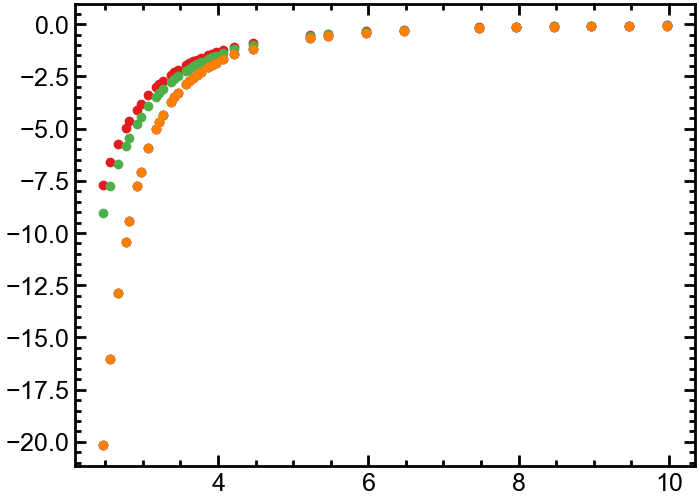

In [56]:
plt.scatter(
    water_pairs_pc.data["OO"], 
    water_pairs_pc.data["ELEC"]
)
plt.scatter(
    water_pairs_pc.data["OO"], 
    water_pairs_pc.data["ECOL"]
)
plt.scatter(
    water_pairs_mdcm.data["OO"], 
    water_pairs_mdcm.data["ELEC"]
)
plt.scatter(
    water_pairs_mdcm.data["OO"], 
    water_pairs_mdcm.data["CI"]
)
plt.scatter(
    water_pairs_mdcm.data["OO"], 
    water_pairs_mdcm.data["ECOL"]
)

In [17]:
water_pairs_mdcm.data.describe()

,ECOL,TOTAL,ELEC,VDW,M_ENERGY,n_monomers,C_ENERGY,P_ENERGY,P_intE,intE,C_ENERGY_kcalmol,OO,CI
count,35.000000,35.000000,35.000000,35.000000,1.100000e+01,11.0,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,-3.999907,15.866388,-2.472650,0.548099,-1.527142e+02,2.0,-152.718137,-152.718137,-2.483954,-2.483954,-95831.088810,4.585714,-3.999907
std,4.755633,0.411027,2.312680,2.001393,2.980894e-14,0.0,0.002834,0.002834,1.778189,1.778189,1.778197,2.138814,4.755633
min,-20.171936,14.394860,-9.061040,-0.195340,-1.527142e+02,2.0,-152.722413,-152.722413,-5.167701,-5.167701,-95833.772569,2.470000,-20.171936
25%,-4.855301,15.609305,-3.389495,-0.154530,-1.527142e+02,2.0,-152.720574,-152.720574,-4.013550,-4.013550,-95832.618413,3.195000,-4.855301
50%,-2.417410,15.950850,-1.923930,-0.030690,-1.527142e+02,2.0,-152.718309,-152.718309,-2.591970,-2.591970,-95831.196827,3.720000,-2.417410
75%,-0.610816,16.176600,-0.526065,-0.000765,-1.527142e+02,2.0,-152.715242,-152.715242,-0.667704,-0.667704,-95829.272551,5.345000,-0.610816
max,-0.072238,16.364170,-0.063710,10.230800,-1.527142e+02,2.0,-152.714294,-152.714294,-0.072558,-0.072558,-95828.677402,9.970000,-0.072238


In [18]:
RCUT = 0
water_pairs_pc.data = water_pairs_pc.data[water_pairs_pc.data["OO"] > RCUT]
water_pairs_mdcm.data = water_pairs_mdcm.data[water_pairs_mdcm.data["OO"] > RCUT]

In [27]:
len(water_pairs_pc.data["intE"])
len(water_pairs_mdcm.data["intE"])

35

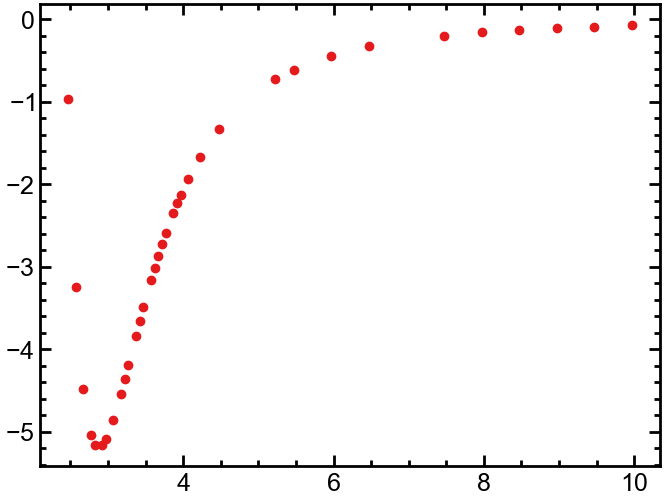

In [20]:
plt.scatter(
    water_pairs_mdcm.data["OO"], 
    water_pairs_mdcm.data["intE"]
)

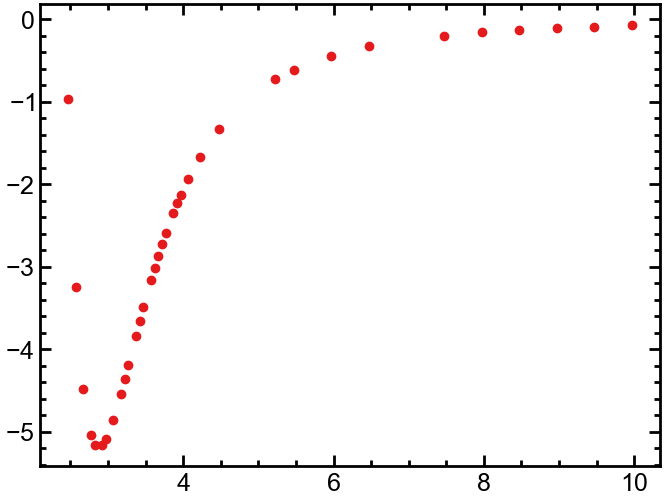

In [55]:
plt.scatter(
    water_pairs_pc.data["OO"], 
    water_pairs_pc.data["intE"]
)

#  Force Feild Object

In [21]:
dists = {str(s.name)[:-4]: s.distances for s in structs}
struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)

In [43]:
len(dists)

35

In [50]:
def ff_train(fit, elec, target, data):
    if fit == "lj":
        FUNC = LJ
        BOUNDS = []
        for i in range(len(set(struct_data.chm_typ))):
            BOUNDS.append(sig_bound)
        for i in range(len(set(struct_data.chm_typ))):
            BOUNDS.append(ep_bound)
    elif fit == "de":
        FUNC = DE
        BOUNDS = []
        for i in range(len(set(struct_data.chm_typ))):
            BOUNDS.append(sig_bound)
        for i in range(len(set(struct_data.chm_typ))):
            BOUNDS.append(ep_bound)
        BOUNDS.append(alpha_bound)
        BOUNDS.append(beta_bound)
    else:
        raise ValueError("Invalid fit type")

    ljpcff = FF(
        data,
        dists,
        FUNC,
        BOUNDS,
        struct_data,
        elec=elec,
        intE=target,
    )
    #  set the targets
    ljpcff.num_segments = len(data)
    print("Nsegments", ljpcff.num_segments)
    ljpcff.set_targets()
    
    if fit == "de":
        loss = "jax_de"
    else:
        loss = "jax"

    ljpcff_fit = fit_repeat(ljpcff,
                     30,
                     "dimer3d_fit",
                     loss=loss,
                           quiet=True)
    return ljpcff_fit


#  PC-LJ

In [62]:
fit = "lj"
elec = "ELEC"
target = "intE"
data = water_pairs_pc.data[["OO", "ELEC", "CI", "intE"]]
print("len(data):", len(data))

ljpcff_fit = ff_train(fit, elec, target, data)

len(data): 35
Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
1-1.xyz    -0.965271
10-1.xyz   -4.366515
11-1.xyz   -4.190640
12-1.xyz   -3.836460
13-1.xyz   -3.662178
14-1.xyz   -3.491717
15-1.xyz   -3.166089
16-1.xyz   -3.012307
17-1.xyz   -2.865234
18-1.xyz   -2.725132
19-1.xyz   -2.591970
2-1.xyz    -3.247532
20-1.xyz   -2.345771
21-1.xyz   -2.232595
22-1.xyz   -2.125882
23-1.xyz   -1.929644
24-1.xyz   -1.673430
25-1.xyz   -1.332308
26-1.xyz   -0.727141
27-1.xyz   -0.608267
28-1.xyz   -0.437317
29-1.xyz   -0.325635
3-1.xyz    -4.481536
30-1.xyz   -0.195253
31-1.xyz   -0.155482
32-1.xyz   -0.125883
33-1.xyz   -0.103462
34-1.xyz   -0.086156
35-1.xyz   -0.072558
4-1.xyz    -5.045602
5-1.xyz    -5.159732
6-1.xyz    -5.167701
7-1.xyz    -5.094541
8-1.xyz    -4.85333

In [65]:
len(data)

35

In [66]:
len(ljpcff_fit.dists)

35

In [67]:
len(data)

35

In [68]:
pd.DataFrame(ljpcff_fit.opt_results).sort_values("fun").head()

,fun,nit,nfev,status,success,message,x,final_simplex
17,0.485982,315,556,0,True,Optimization terminated successfully.,"[1.4176232224922636, 0.6704797516703764, 0.1, ...","([[1.4176232224922636, 0.6704797516703764, 0.1..."
1,0.485982,185,337,0,True,Optimization terminated successfully.,"[1.4176241991099092, 0.6704771717381782, 0.1, ...","([[1.4176241991099092, 0.6704771717381782, 0.1..."
8,0.485982,226,416,0,True,Optimization terminated successfully.,"[1.417650103305397, 0.6704519635514441, 0.1, 0...","([[1.417650103305397, 0.6704519635514441, 0.1,..."
27,0.485982,285,505,0,True,Optimization terminated successfully.,"[1.417675169920163, 0.6703144174982265, 0.0999...","([[1.417675169920163, 0.6703144174982265, 0.09..."
5,0.485984,239,421,0,True,Optimization terminated successfully.,"[1.4180833764134708, 0.6693270388569541, 0.099...","([[1.4180833764134708, 0.6693270388569541, 0.0..."


In [69]:
ljpcff_fit.eval_best_parm()

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


,LJ
KEY,
1-1.xyz,6.959202
10-1.xyz,-0.344850
11-1.xyz,-0.331107
12-1.xyz,-0.298197
13-1.xyz,-0.280763
14-1.xyz,-0.263406
15-1.xyz,-0.230135
16-1.xyz,-0.214574
17-1.xyz,-0.199849


Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


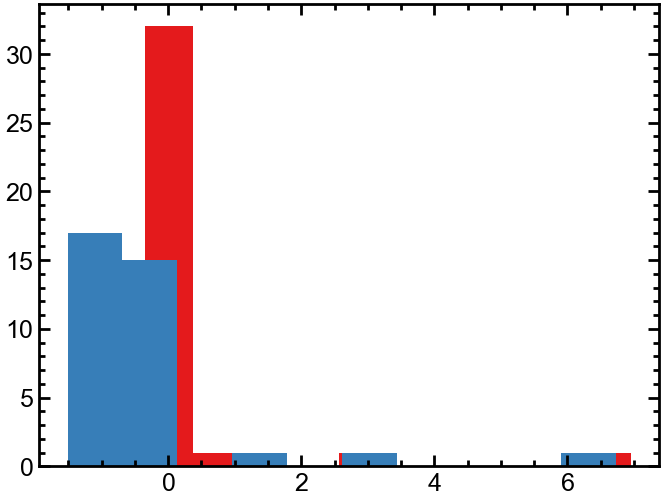

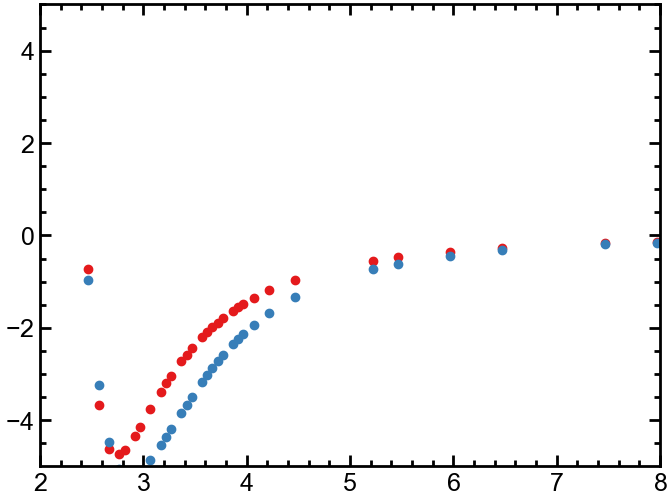

(-5.0, 5.0)

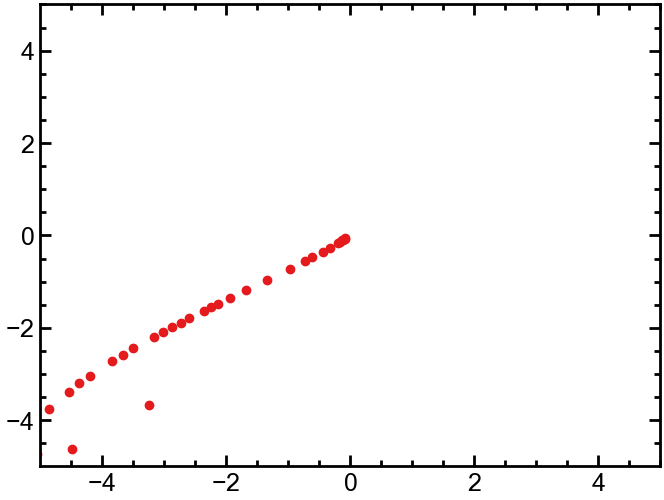

In [70]:
ffeval = ljpcff_fit.eval_best_parm()

plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

ljpcff_fit.data["eval"] = ffeval

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"]
)

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    ljpcff_fit.data["intE"],
    ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"],
           )

LJPC = ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"]

plt.xlim(-5,5)
plt.ylim(-5,5)

#  PC-DE

In [74]:
fit = "de"
elec = "ELEC"
target = "intE"
data = water_pairs_pc.data[["OO", "ELEC", "CI", "intE"]]
depcff_fit = ff_train(fit, elec, target, data)

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 6 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (1, 8), (6, 20)]
Interaction energy:
KEY
1-1.xyz    -0.965271
10-1.xyz   -4.366515
11-1.xyz   -4.190640
12-1.xyz   -3.836460
13-1.xyz   -3.662178
14-1.xyz   -3.491717
15-1.xyz   -3.166089
16-1.xyz   -3.012307
17-1.xyz   -2.865234
18-1.xyz   -2.725132
19-1.xyz   -2.591970
2-1.xyz    -3.247532
20-1.xyz   -2.345771
21-1.xyz   -2.232595
22-1.xyz   -2.125882
23-1.xyz   -1.929644
24-1.xyz   -1.673430
25-1.xyz   -1.332308
26-1.xyz   -0.727141
27-1.xyz   -0.608267
28-1.xyz   -0.437317
29-1.xyz   -0.325635
3-1.xyz    -4.481536
30-1.xyz   -0.195253
31-1.xyz   -0.155482
32-1.xyz   -0.125883
33-1.xyz   -0.103462
34-1.xyz   -0.086156
35-1.xyz   -0.072558
4-1.xyz    -5.045602
5-1.xyz    -5.159732
6-1.xyz    -5.167701
7-1.xyz    -5.094541
8-1.xyz    -4.85

In [75]:
res = pd.DataFrame(depcff_fit.opt_results).sort_values("fun")
parm = res["x"].iloc[0]
res.head()

,fun,nit,nfev,status,success,message,x,final_simplex
14,0.198663,661,1059,0,True,Optimization terminated successfully.,"[1.4479286538249727, 1.0726209056258804, 0.099...","([[1.4479286538249727, 1.0726209056258804, 0.0..."
16,0.198663,312,573,0,True,Optimization terminated successfully.,"[1.448036885878702, 1.0725858748564197, 0.0999...","([[1.448036885878702, 1.0725858748564197, 0.09..."
22,0.198663,696,1116,0,True,Optimization terminated successfully.,"[1.4479095114102227, 1.0726156861404927, 0.099...","([[1.4479095114102227, 1.0726156861404927, 0.0..."
13,0.198663,673,1108,0,True,Optimization terminated successfully.,"[1.4480274103785749, 1.0724337831487618, 0.099...","([[1.4480274103785749, 1.0724337831487618, 0.0..."
19,0.198663,721,1156,0,True,Optimization terminated successfully.,"[1.4478062599738277, 1.0728843242318005, 0.099...","([[1.4478062599738277, 1.0728843242318005, 0.0..."


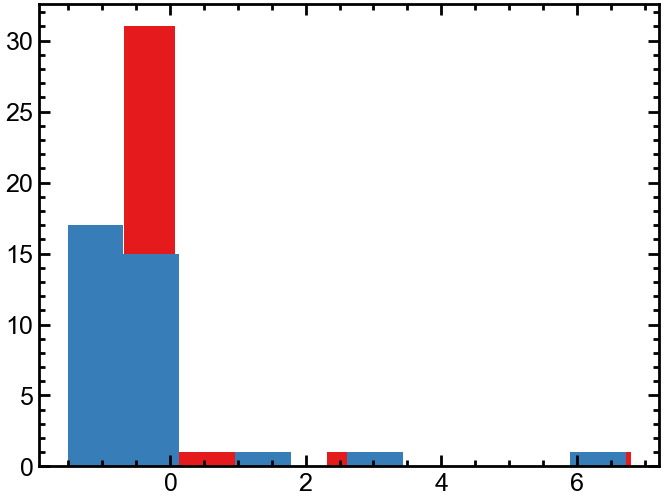

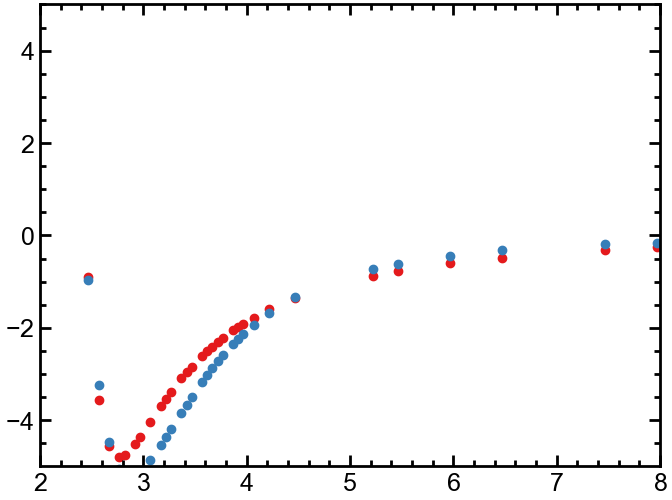

(-5.0, 5.0)

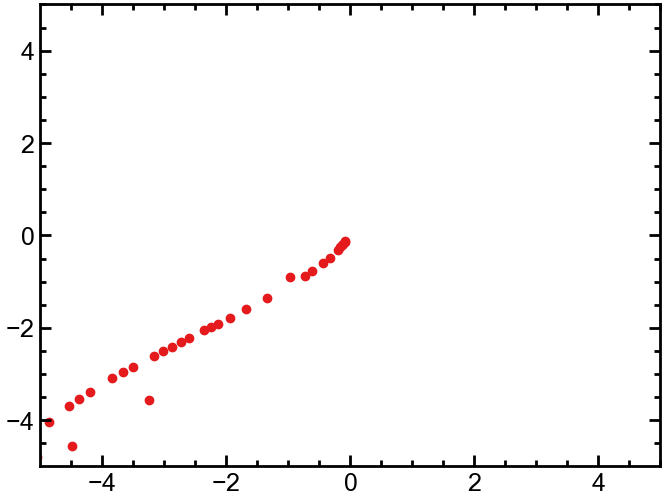

In [76]:
ffeval = depcff_fit.eval_jax_de(parm)
plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

depcff_fit.data["eval"] = ffeval

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"]
)

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    depcff_fit.data["intE"],
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"],
           )
DEPC = depcff_fit.data["eval"] + depcff_fit.data["ELEC"]
plt.xlim(-5,5)
plt.ylim(-5,5)

#  CI-LJ

In [77]:
fit = "lj"
elec = "CI"
target = "intE"
data = water_pairs_pc.data[["OO", "ELEC", "CI", "intE"]]
ljpcff_fit = ff_train(fit, elec, target, data)

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
1-1.xyz    -0.965271
10-1.xyz   -4.366515
11-1.xyz   -4.190640
12-1.xyz   -3.836460
13-1.xyz   -3.662178
14-1.xyz   -3.491717
15-1.xyz   -3.166089
16-1.xyz   -3.012307
17-1.xyz   -2.865234
18-1.xyz   -2.725132
19-1.xyz   -2.591970
2-1.xyz    -3.247532
20-1.xyz   -2.345771
21-1.xyz   -2.232595
22-1.xyz   -2.125882
23-1.xyz   -1.929644
24-1.xyz   -1.673430
25-1.xyz   -1.332308
26-1.xyz   -0.727141
27-1.xyz   -0.608267
28-1.xyz   -0.437317
29-1.xyz   -0.325635
3-1.xyz    -4.481536
30-1.xyz   -0.195253
31-1.xyz   -0.155482
32-1.xyz   -0.125883
33-1.xyz   -0.103462
34-1.xyz   -0.086156
35-1.xyz   -0.072558
4-1.xyz    -5.045602
5-1.xyz    -5.159732
6-1.xyz    -5.167701
7-1.xyz    -5.094541
8-1.xyz    -4.853336
9-1.xyz    -

In [78]:
pd.DataFrame(ljpcff_fit.opt_results).sort_values("fun").head()

,fun,nit,nfev,status,success,message,x,final_simplex
17,0.138327,325,589,0,True,Optimization terminated successfully.,"[0.10000000000000003, 2.2145225675720392, 0.00...","([[0.10000000000000003, 2.2145225675720392, 0...."
21,0.138327,353,640,0,True,Optimization terminated successfully.,"[0.10000000000001788, 2.2139217386545935, 0.00...","([[0.10000000000001788, 2.2139217386545935, 0...."
25,0.138327,210,386,0,True,Optimization terminated successfully.,"[0.10000000000000725, 2.213238183247471, 0.001...","([[0.10000000000000725, 2.213238183247471, 0.0..."
0,0.138327,206,390,0,True,Optimization terminated successfully.,"[0.10000000000000003, 2.2128668350808094, 0.00...","([[0.10000000000000003, 2.2128668350808094, 0...."
27,0.138327,287,531,0,True,Optimization terminated successfully.,"[0.10000000000000014, 2.214449850970836, 0.001...","([[0.10000000000000014, 2.214449850970836, 0.0..."


Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


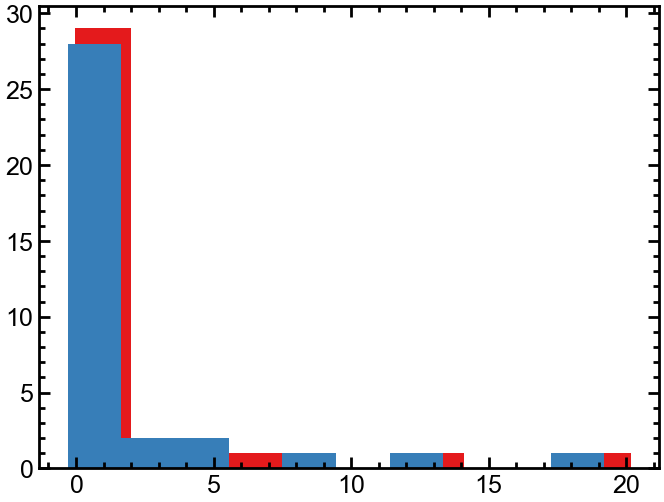

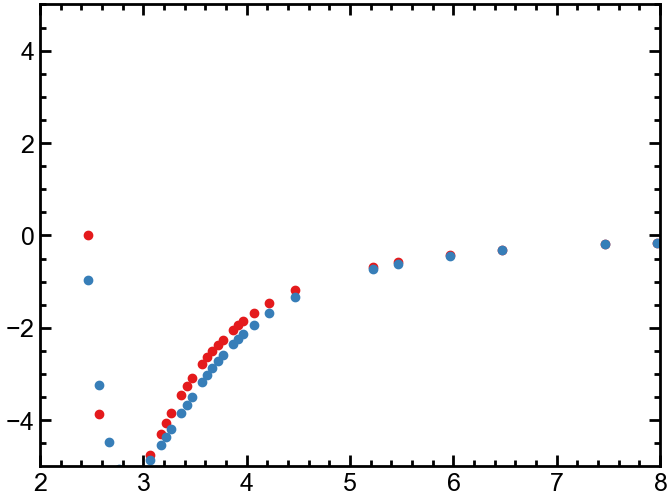

(-5.0, 5.0)

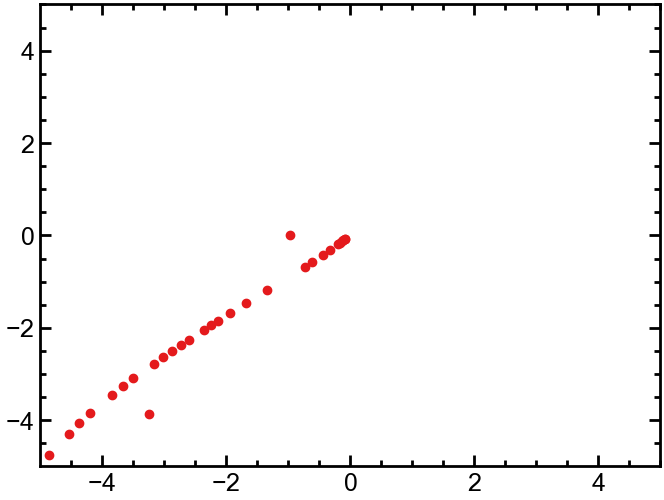

In [79]:
ffeval = ljpcff_fit.eval_best_parm()
plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

ljpcff_fit.data["eval"] = ffeval

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["eval"] + ljpcff_fit.data["CI"]
)

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    ljpcff_fit.data["intE"],
    ljpcff_fit.data["eval"] + ljpcff_fit.data["CI"],
           )

LJCI = ljpcff_fit.data["eval"] + ljpcff_fit.data["CI"]

plt.xlim(-5,5)
plt.ylim(-5,5)

#  CI-DE

In [81]:
fit = "de"
elec = "CI"
target = "intE"
data = water_pairs_pc.data[["OO", "ELEC", "CI", "intE"]]
depcff_fit = ff_train(fit, elec, target, data)

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 6 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (1, 8), (6, 20)]
Interaction energy:
KEY
1-1.xyz    -0.965271
10-1.xyz   -4.366515
11-1.xyz   -4.190640
12-1.xyz   -3.836460
13-1.xyz   -3.662178
14-1.xyz   -3.491717
15-1.xyz   -3.166089
16-1.xyz   -3.012307
17-1.xyz   -2.865234
18-1.xyz   -2.725132
19-1.xyz   -2.591970
2-1.xyz    -3.247532
20-1.xyz   -2.345771
21-1.xyz   -2.232595
22-1.xyz   -2.125882
23-1.xyz   -1.929644
24-1.xyz   -1.673430
25-1.xyz   -1.332308
26-1.xyz   -0.727141
27-1.xyz   -0.608267
28-1.xyz   -0.437317
29-1.xyz   -0.325635
3-1.xyz    -4.481536
30-1.xyz   -0.195253
31-1.xyz   -0.155482
32-1.xyz   -0.125883
33-1.xyz   -0.103462
34-1.xyz   -0.086156
35-1.xyz   -0.072558
4-1.xyz    -5.045602
5-1.xyz    -5.159732
6-1.xyz    -5.167701
7-1.xyz    -5.094541
8-1.xyz    -4.85

In [82]:
res = pd.DataFrame(depcff_fit.opt_results).sort_values("fun")
parm = res["x"].iloc[0]
res.head()

,fun,nit,nfev,status,success,message,x,final_simplex
8,0.000058,418,718,0,True,Optimization terminated successfully.,"[1.687768238291489, 1.200069028712666, 0.08978...","([[1.687768238291489, 1.200069028712666, 0.089..."
23,0.000064,1100,1760,0,True,Optimization terminated successfully.,"[1.7139624400846107, 1.0924083265474516, 0.078...","([[1.7139624400846107, 1.0924083265474516, 0.0..."
29,0.000075,1173,1887,0,True,Optimization terminated successfully.,"[1.7126304736830384, 1.0780454070953018, 0.097...","([[1.7126304736830384, 1.0780454070953018, 0.0..."
18,0.000131,1837,2893,0,True,Optimization terminated successfully.,"[1.7372037091784835, 0.7892437130462636, 0.099...","([[1.7372037091784835, 0.7892437130462636, 0.0..."
10,0.000351,1502,2399,0,True,Optimization terminated successfully.,"[1.695263615317038, 1.2285147251119013, 0.0960...","([[1.695263615317038, 1.2285147251119013, 0.09..."


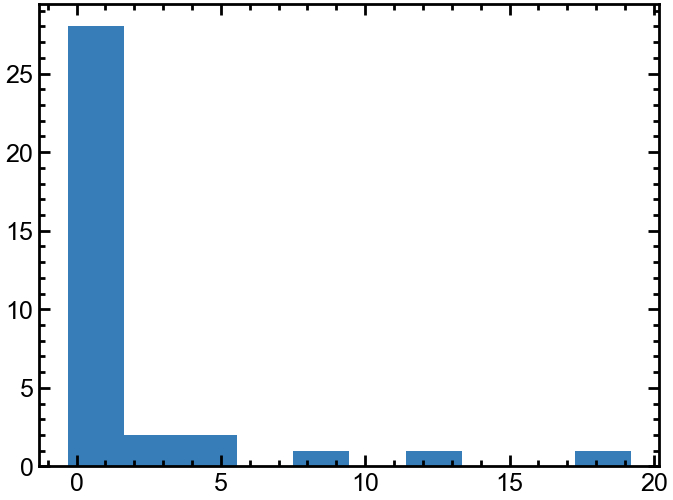

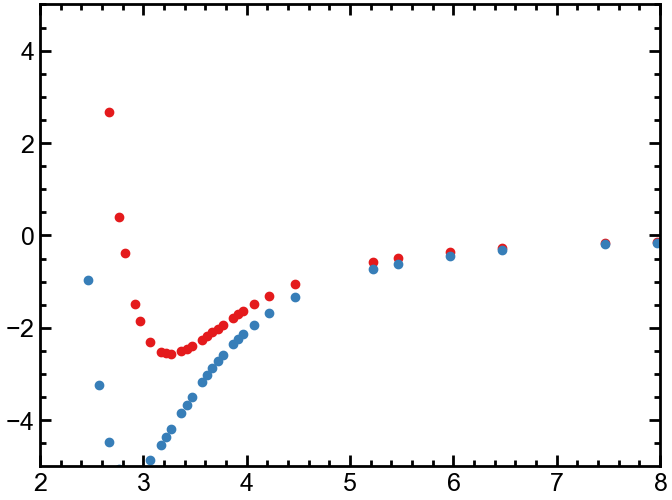

(-5.0, 5.0)

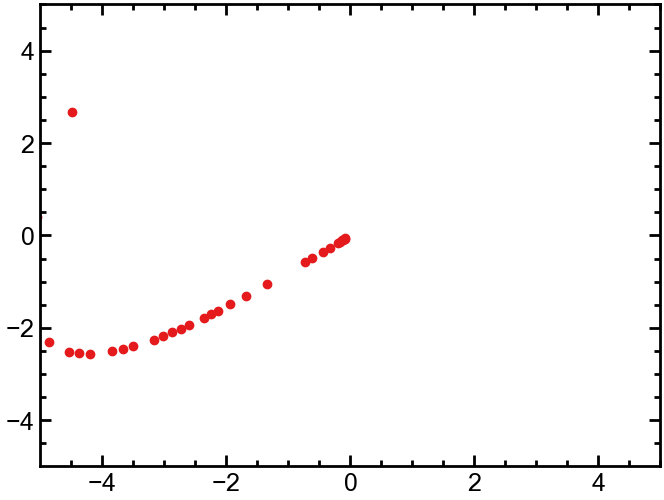

In [83]:
ffeval = depcff_fit.eval_jax_de(parm)
plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

depcff_fit.data["eval"] = ffeval

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"]
)

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    depcff_fit.data["intE"],
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"],
           )

DECI = depcff_fit.data["eval"] + depcff_fit.data["CI"]

plt.xlim(-5,5)
plt.ylim(-5,5)

#  MDCM - LJ

In [84]:
fit = "lj"
elec = "ELEC"
target = "intE"
data = water_pairs_mdcm.data[["OO", "ELEC", "CI", "intE"]]
ljpcff_fit = ff_train(fit, elec, target, data)

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
1-1.xyz    -0.965271
10-1.xyz   -4.366515
11-1.xyz   -4.190640
12-1.xyz   -3.836460
13-1.xyz   -3.662178
14-1.xyz   -3.491717
15-1.xyz   -3.166089
16-1.xyz   -3.012307
17-1.xyz   -2.865234
18-1.xyz   -2.725132
19-1.xyz   -2.591970
2-1.xyz    -3.247532
20-1.xyz   -2.345771
21-1.xyz   -2.232595
22-1.xyz   -2.125882
23-1.xyz   -1.929644
24-1.xyz   -1.673430
25-1.xyz   -1.332308
26-1.xyz   -0.727141
27-1.xyz   -0.608267
28-1.xyz   -0.437317
29-1.xyz   -0.325635
3-1.xyz    -4.481536
30-1.xyz   -0.195253
31-1.xyz   -0.155482
32-1.xyz   -0.125883
33-1.xyz   -0.103462
34-1.xyz   -0.086156
35-1.xyz   -0.072558
4-1.xyz    -5.045602
5-1.xyz    -5.159732
6-1.xyz    -5.167701
7-1.xyz    -5.094541
8-1.xyz    -4.853336
9-1.xyz    -

In [85]:
pd.DataFrame(ljpcff_fit.opt_results).sort_values("fun").head()

,fun,nit,nfev,status,success,message,x,final_simplex
20,0.218119,330,606,0,True,Optimization terminated successfully.,"[1.4867017857097014, 0.5029079476943875, 0.1, ...","([[1.4867017857097014, 0.5029079476943875, 0.1..."
8,0.218119,220,403,0,True,Optimization terminated successfully.,"[1.4866996574031752, 0.5028909911716126, 0.1, ...","([[1.4866996574031752, 0.5028909911716126, 0.1..."
6,0.218119,467,801,0,True,Optimization terminated successfully.,"[1.4866823771209519, 0.5030434460061977, 0.1, ...","([[1.4866823771209519, 0.5030434460061977, 0.1..."
25,0.218119,176,326,0,True,Optimization terminated successfully.,"[1.486711512231976, 0.5029657344767713, 0.1, 0.1]","([[1.486711512231976, 0.5029657344767713, 0.1,..."
16,0.218119,334,611,0,True,Optimization terminated successfully.,"[1.4867546509883829, 0.5025974648129274, 0.1, ...","([[1.4867546509883829, 0.5025974648129274, 0.1..."


Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


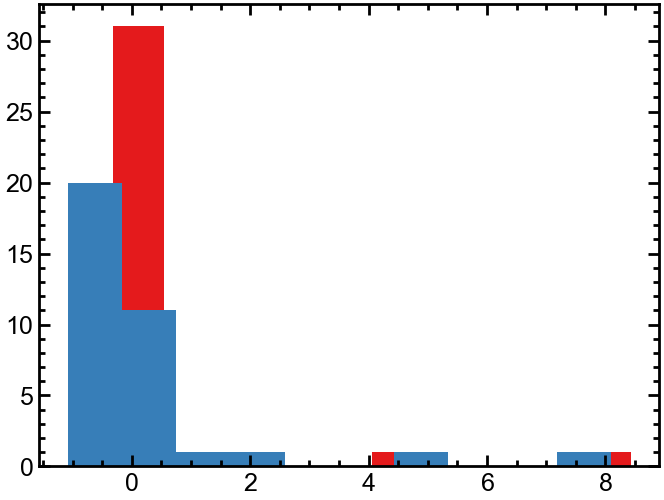

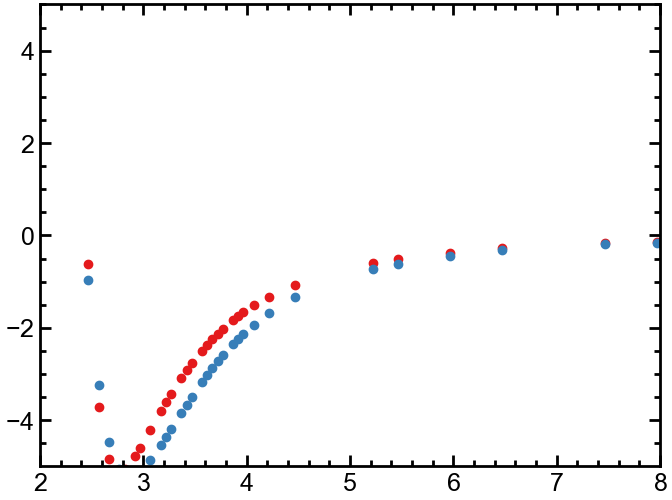

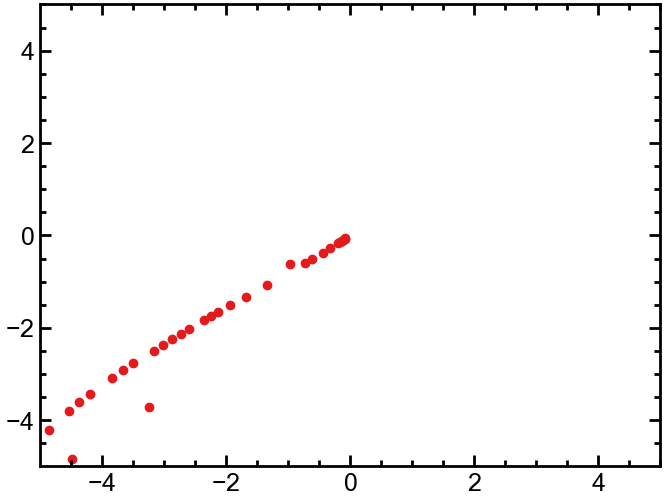

In [86]:
ffeval = ljpcff_fit.eval_best_parm()
plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

ljpcff_fit.data["eval"] = ffeval

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"]
)

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    ljpcff_fit.data["intE"],
    ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"],
           )

plt.xlim(-5,5)
plt.ylim(-5,5)

LJMDCM = ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"]

#  MDCM - DE

In [87]:
fit = "de"
elec = "ELEC"
target = "intE"
data = water_pairs_mdcm.data[["OO", "ELEC", "CI", "intE"]]
depcff_fit = ff_train(fit, elec, target, data)

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 6 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (1, 8), (6, 20)]
Interaction energy:
KEY
1-1.xyz    -0.965271
10-1.xyz   -4.366515
11-1.xyz   -4.190640
12-1.xyz   -3.836460
13-1.xyz   -3.662178
14-1.xyz   -3.491717
15-1.xyz   -3.166089
16-1.xyz   -3.012307
17-1.xyz   -2.865234
18-1.xyz   -2.725132
19-1.xyz   -2.591970
2-1.xyz    -3.247532
20-1.xyz   -2.345771
21-1.xyz   -2.232595
22-1.xyz   -2.125882
23-1.xyz   -1.929644
24-1.xyz   -1.673430
25-1.xyz   -1.332308
26-1.xyz   -0.727141
27-1.xyz   -0.608267
28-1.xyz   -0.437317
29-1.xyz   -0.325635
3-1.xyz    -4.481536
30-1.xyz   -0.195253
31-1.xyz   -0.155482
32-1.xyz   -0.125883
33-1.xyz   -0.103462
34-1.xyz   -0.086156
35-1.xyz   -0.072558
4-1.xyz    -5.045602
5-1.xyz    -5.159732
6-1.xyz    -5.167701
7-1.xyz    -5.094541
8-1.xyz    -4.85

In [88]:
res = pd.DataFrame(depcff_fit.opt_results).sort_values("fun")
parm = res["x"].iloc[0]
res.head()

,fun,nit,nfev,status,success,message,x,final_simplex
3,0.050655,810,1319,0,True,Optimization terminated successfully.,"[1.4995957791269212, 1.2203545427202025, 0.099...","([[1.4995957791269212, 1.2203545427202025, 0.0..."
10,0.050655,764,1247,0,True,Optimization terminated successfully.,"[1.499818911209346, 1.2201666308504993, 0.0999...","([[1.499818911209346, 1.2201666308504993, 0.09..."
18,0.050655,1032,1643,0,True,Optimization terminated successfully.,"[1.4994931679448538, 1.2205628200233425, 0.099...","([[1.4994931679448538, 1.2205628200233425, 0.0..."
7,0.050656,1071,1704,0,True,Optimization terminated successfully.,"[1.4995099231639673, 1.2207416175321448, 0.099...","([[1.4995099231639673, 1.2207416175321448, 0.0..."
26,0.050656,819,1321,0,True,Optimization terminated successfully.,"[1.499758544074509, 1.220319079996453, 0.09999...","([[1.499758544074509, 1.220319079996453, 0.099..."


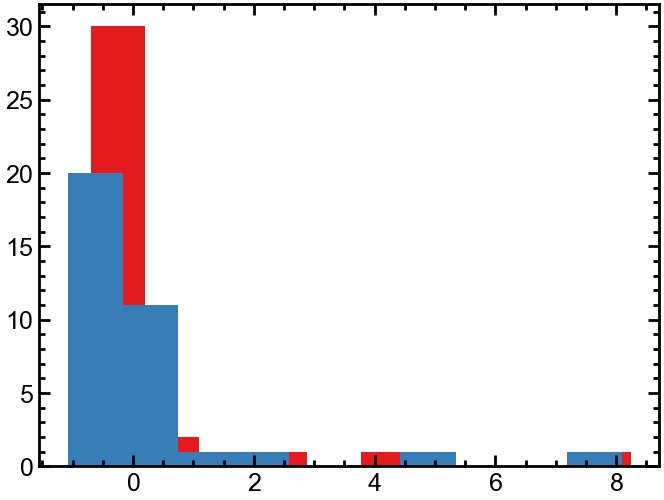

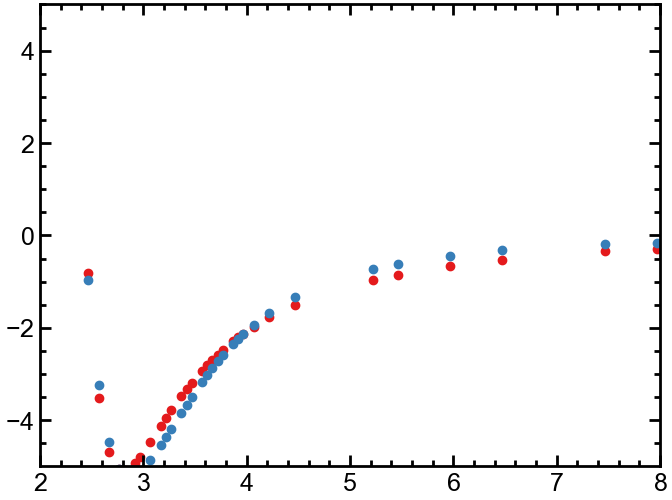

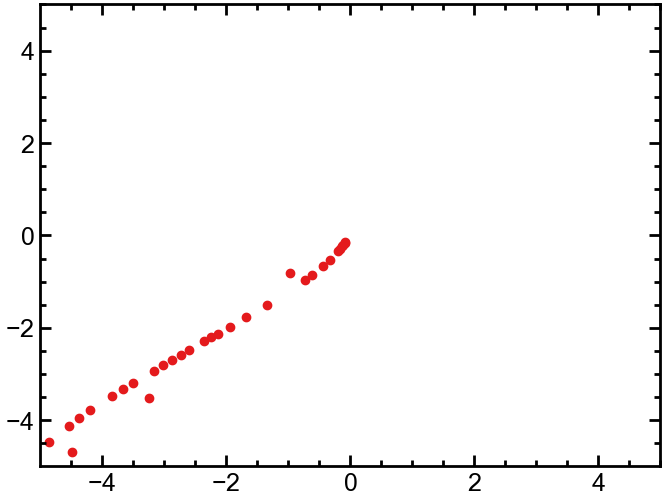

In [89]:
ffeval = depcff_fit.eval_jax_de(parm)
plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

depcff_fit.data["eval"] = ffeval

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"]
)

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    depcff_fit.data["intE"],
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"],
           )

plt.xlim(-5,5)
plt.ylim(-5,5)


DEMDCM = depcff_fit.data["eval"] + depcff_fit.data["ELEC"]


In [90]:
# popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))

In [97]:

marker_style = dict(color='tab:blue', linestyle=':', marker='o',
                    markersize=15, markerfacecoloralt='tab:red')

def plot_scan(x, y, ax, c="k", nox=False, N=20, linestyle="-"):
    ax.scatter(x, y, marker="o", s=8, c=c, 
            alpha=0.9, facecolor='none', linewidth=7)
    # ax.scatter(x, y, "o", markersize=2, c=c, alpha=0.6)

    if N>0:
        coefs = np.polyfit(x, y, N)
        p = np.poly1d(coefs)
        XRange = np.arange(0,8,0.1)
        ax.plot(XRange, p(XRange), linestyle, c=c, alpha=0.9, linewidth=2.25)
    # if N==-1:
        
    ax.axhline(c="k", linestyle="--")
    return ax

2023-10-27 13:43:21 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-10-27 13:43:21 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-10-27 13:43:21 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-10-27 13:43:21 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-10-27 13:43:21 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-10-27 13:43:21 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-10-27 13:43:21 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-10-27 13:43:21 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-10-27 13:43:21 | DEBUG | ttFont:_readTable:459 - Reading 'post' table from disk
2023-10-27 13:43:21 | DEBUG | ttFont:_readTable:468 - Decompiling 'post' table
2023-10-27 13:43:21 | DEBUG | loggingTools:__exit__:357 - Took 0.006s to load 'cmap'
2023-10-27 13:43:21 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-10-

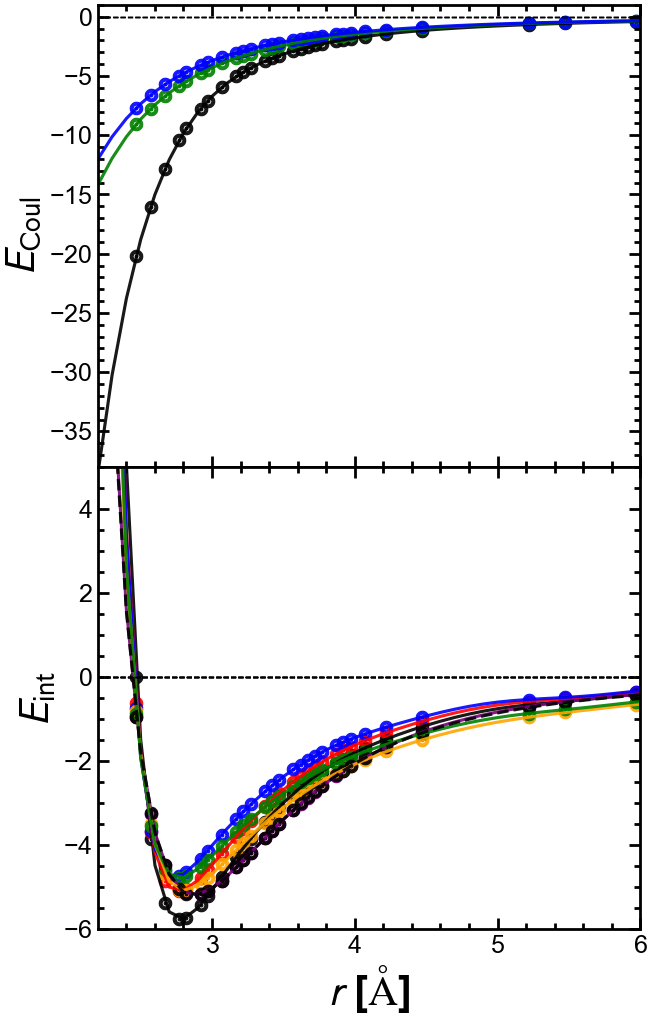

In [98]:
fig, ax = plt.subplots(2,1, figsize=(7,12), sharex=True)


NCol = 12
plot_scan(water_pairs_pc.data["OO"], 
    water_pairs_pc.data["CI"], ax[0], N=NCol, c="k")
plot_scan(water_pairs_mdcm.data["OO"], 
    water_pairs_mdcm.data["ELEC"], ax[0], N=NCol, c="green")
plot_scan(water_pairs_pc.data["OO"], 
    water_pairs_pc.data["ELEC"], ax[0], N=NCol, c="blue")


NINT = 18

plot_scan(water_pairs_pc.data["OO"], 
    [LJCI.loc[i] for i in order if i in LJCI.index], ax[1],
          N=NINT, c="k")
plot_scan(water_pairs_mdcm.data["OO"], 
    [LJMDCM.loc[i] for i in order if i in LJCI.index], ax[1], 
          N=NINT, c="red")
plot_scan(water_pairs_pc.data["OO"], 
    [LJPC.loc[i] for i in order if i in LJCI.index], ax[1],
          N=NINT, c="blue")

plot_scan(water_pairs_pc.data["OO"], 
    [DECI.loc[i] for i in order if i in LJCI.index], ax[1],
          N=NINT, c="purple")
plot_scan(water_pairs_mdcm.data["OO"], 
    [DEMDCM.loc[i] for i in order if i in LJCI.index], ax[1], 
          N=NINT, c="orange")
plot_scan(water_pairs_pc.data["OO"], 
    [DEPC.loc[i] for i in order if i in LJCI.index], ax[1], 
          N=NINT, c="green")

plot_scan(water_pairs_pc.data["OO"], 
    water_pairs_pc.data["intE"], ax[1], N=NINT, c="black", linestyle="--")

ax[0].set_ylim(-38,1)
ax[0].set_xlim(2.2,6)

ax[1].set_ylim(-6.,5)
ax[1].set_xlim(2.2,6)

ax[1].set_ylabel("$E_{\mathrm{int}}$", fontsize=30)
ax[1].set_ylabel("$E_{\mathrm{int}}$", fontsize=30)
ax[0].set_ylabel("$E_{\mathrm{Coul}}$", fontsize=30)
ax[1].set_xlabel("$r$ [$\mathrm{\AA}$]", fontsize=30)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("water_dimer.pdf")